In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as onp
import itertools
import datetime
import tqdm
import sys
import os

import jax.numpy as np

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


COLOR_LIST1 = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [2]:
class Patient:
    susceptible = 0
    colonized   = 1

class Observed:
    no  = 0
    yes = 1

In [26]:
def amr_abm(t, agents_state, gamma, beta, alpha, movement, ward2size, Np):
    """ Agent based model tracking colonized and susceptible patients with pre-defined movement patterns.

    Args:
        agents_state : agent state. {0: Patient.susceptible, 1: Patient.colonized}  Size: (n_patients)
        movement     : pd.Dataframe with patient locations and culture information.
        parameters   : dictionary of parameters, contains importation rate (gamma), nosocomial transmission rate (beta),
                        effective sensitivity (ro), and decolonization rate (alpha)
    """
    agents_state = onp.array(agents_state)
    _, m = agents_state.shape

    γ   = gamma            # importation rate.
    β   = beta             # nosocomial transmission rate.
    α   = alpha            # decolonization rate.
    Np  = Np               # number of patients

    # Decolonize patients according to. P(C2S) = α
    #agents_state.at[:].set(np.maximum(agents_state - agents_state * (random.uniform(key=key, shape=(Np, )) < α), 0))
    #agents_state = agents_state - agents_state * (onp.random.uniform(size=(Np, )) < α)
    p_update = agents_state.copy()
    p_update = Patient.susceptible * (agents_state * onp.random.random(size=(Np, m)) <= α)

    # import patients.
    new_patients = movement[movement["first_day"]==1]["mrn_id"].values
    if new_patients.shape[0] > 0:
        # P(S2C) = \gamma - Probability of colonization given importation.
        #agents_state[new_patients] = Patient.colonized * (random.uniform(key=key, shape=(new_patients.shape[0], )) < γ)
        p_update[new_patients] = Patient.colonized * (onp.random.random(size=(new_patients.shape[0], m)) <= γ)

    # Compute force of infection for each ward.
    for i, ward_id in enumerate(movement["ward_id"].unique()):
        patients_ward = movement[movement["ward_id"]==ward_id]["mrn_id"].values

        # λ_i = β  * C / N  - Force of infection for ward i.
        λ_i = β * onp.sum(p_update[patients_ward]==Patient.colonized) / ward2size[ward_id]

        # P(C2S)_i = λ_i, we add the state but if already colonized the state would be 2 so we clip it to 1.
        # agents_state[patients_ward] = Patient.colonized * np.minimum(agents_state[patients_ward] + random.uniform(key=key, shape=(patients_ward.shape[0], )) < λ_i, 1)

        p_update[patients_ward] = p_update[patients_ward] + Patient.colonized * (onp.random.random(size=(patients_ward.shape[0], m)) <= λ_i)
    p_update = onp.clip(p_update, 0, 1)
    return p_update


def observe_cluster(t, patients_state, movement, rho, Nc):
    _, m           = patients_state.shape

    ρ              = rho # effective sensitivity.
    Nc             = Nc  # number of clusters

    cluster_positive  = onp.zeros((Nc, m))
    p_test            = Observed.yes * (onp.random.random(size=(patients_state.shape[0], m)) <= patients_state * ρ)

    for i, cluster in enumerate(movement["cluster"].unique()):
        patients_test_ward            = movement.query(f"cluster=={cluster} and test==True")["mrn_id"].values
        cluster_positive[cluster,  :] = onp.sum(p_test[patients_test_ward, :]    == Observed.yes, axis=0)

    return cluster_positive


def f0(parameters, model_settings):
    """ Initial state of the model.
    """
    Np = parameters["Np"]     # number of patients.
    m  = model_settings["m"]  # number of ensembles.

    patient_state = onp.zeros((Np, m))
    return patient_state

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_89371/1634364989.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_89371/1634364989.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_diag_df["cluster"][cluster_diag_df.cluster>=6] = 6


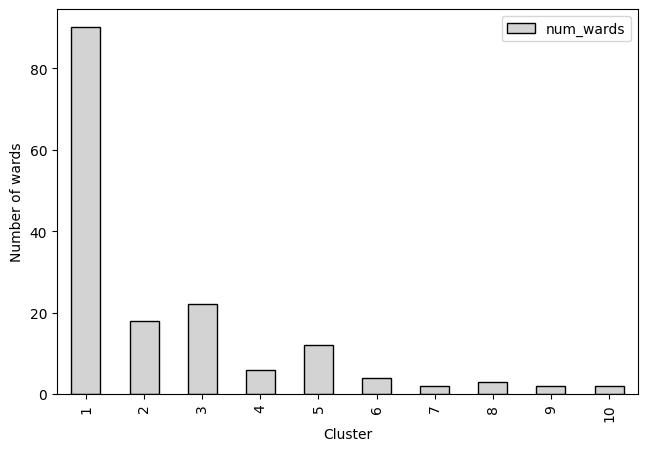

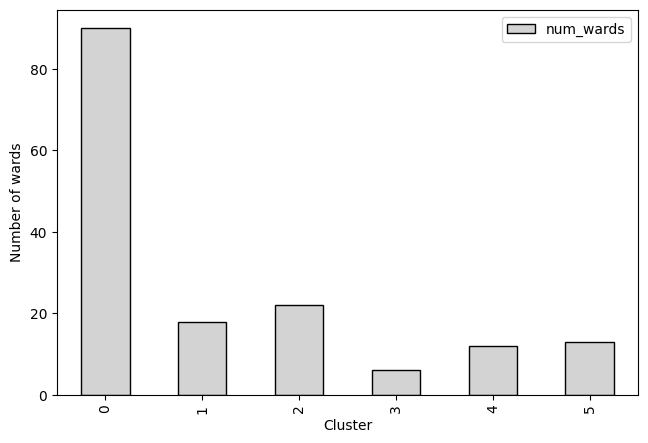

In [27]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df               = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"] = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df               = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id  = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id = {ward_name: id for id, ward_name in enumerate(movement_df.ward_total.unique())}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###
cluster_diag_df              = pd.read_csv("infomap_nondiag.csv", sep=" ").rename(columns={"node_id": "ward_id"})
cluster_diag_df["ward_name"] = cluster_diag_df["ward_id"].map(id2ward)
cluster_diag_df["cluster"]   = cluster_diag_df.apply(lambda x: int(str(x.path).split(":")[0]), axis=1)
cluster_diag_df              = cluster_diag_df[["cluster", "ward_id", "ward_name"]].sort_values(by="cluster")
cluster_diag_df['num_wards'] = cluster_diag_df["cluster"].apply(lambda x: onp.sum(cluster_diag_df["cluster"] == x))


cluster_diag_df[["cluster", "num_wards"]].drop_duplicates(keep="first").plot(kind     = "bar",
                                                                            x         = "cluster",
                                                                            y         = "num_wards",
                                                                            facecolor = "lightgray",
                                                                            edgecolor = "black",
                                                                            figsize=(7.5, 5),
                                                                            xlabel="Cluster", ylabel="Number of wards")


cluster_diag_df["cluster"][cluster_diag_df.cluster>=6] = 6
cluster_diag_df["cluster"] = cluster_diag_df["cluster"].map(lambda x: int(x-1))


cluster_diag_df['num_wards']                           = cluster_diag_df["cluster"].apply(lambda x: onp.sum(cluster_diag_df["cluster"] == x))

cluster_diag_df[["cluster", "num_wards"]].drop_duplicates(keep="first").plot(kind     = "bar",
                                                                            x         = "cluster",
                                                                            y         = "num_wards",
                                                                            facecolor = "lightgray",
                                                                            edgecolor = "black",
                                                                            figsize=(7.5, 5),
                                                                            xlabel="Cluster",
                                                                            ylabel="Number of wards")


wardid2cluster         = dict(zip(cluster_diag_df["ward_id"], cluster_diag_df["cluster"]))
movement_df["cluster"] = movement_df["ward_id"].map( wardid2cluster )
movement_df["cluster"] = movement_df["cluster"].fillna(cluster_diag_df.cluster.max())
movement_df["cluster"] = movement_df["cluster"].map(lambda x: int(x))


In [28]:
import sys
sys.path.insert(0, "./pompjax")

from pompjax import ifeakf


In [32]:

model_settings = {
    "m"           : 100,                                         # number of ensembles
    "p"           : 2,                                           # number of parameters
    "k"           : movement_df["cluster"].unique().shape[0],    # number of observations
    "n"           : 1,                                           # number of state variables / dimension of the state space
    "dt"          : 1,                                           # time step
    "param_name"  : ["β", "γ", "ρ"],                             # name of the parameters
    "dates"       : dates_simulation                             # integration dates (for the process model) | date_{t+1}-date_t = dt
    # "param_truth" : [beta_truth, gamma_truth, report_rate_truth] # true parameter values (not required - just for the example)
    }

# drop first month of data
dates_assimilation = pd.date_range(start="2020-02-28", end="2021-02-28", freq="W-Sun")


if_settings = {
   "Nif"                : 20,                               # number of iterations of the IF
   "type_cooling"       : "geometric",                      # type of cooling schedule
   "shrinkage_factor"   : 0.9,                              # shrinkage factor for the cooling schedule
   "inflation"          : 1.01,                             # inflation factor for spreading the variance after the EAKF step
   "assimilation_dates" : dates_assimilation,               # assimilation dates (for the inference)
   "adjust_state_space" : False                             # whether to adjust the state space x or not.
}

# amr_abm(agents_state, gamma, beta, alpha, movement, ward2size, parameters)

# Function to be used for the ikeafk function.
#amr_abm(t, x, agents_state, gamma, beta, alpha, movement, ward2size, parameters)


gamma = 15/100
alpha = 1/120
Np    = movement_df.mrn_id.unique().shape[0]
Nc    = movement_df.cluster.unique().shape[0]
m     = model_settings["m"]

p_status = onp.zeros((Np, m))

                 # amr_abm(t, agents_state, gamma, beta, alpha, movement, ward2size, Np)
f0_if  = lambda θ: amr_abm(0, p_status, gamma, θ[0, :], alpha, movement_df[movement_df["date"]==dates_simulation[0]], ward2size, Np)
f_if   = lambda t, x, θ: amr_abm(t, x, gamma, θ[0, :], alpha, movement_df[movement_df["date"]==dates_simulation[t]], ward2size, Np)
# observe_cluster(t, patients_state, movement, rho, Nc)
g_if   = lambda t, x, θ: observe_cluster(t, x, movement_df[movement_df["date"]==dates_simulation[t]], θ[1, :], Nc=model_settings["k"])

βmin = 0.001
βmax = 0.8

ρmin = 1/100
ρmax = 15/100

state_space_range = onp.array([0, 1])
parameters_range  = onp.array([[βmin, βmax],
                              [ρmin, ρmax]])

In [36]:
p_status = onp.zeros((Np, m))
gammaaaa = 0.15 * onp.ones((1, m))

teta0 = onp.array([0.15 * onp.ones((1, m)), 6/100 * onp.ones((1, m))])

x       = f0_if(teta0)
x       = f_if(1, x, teta0)
observe = g_if(1, x, teta0)

In [37]:
observe.shape

(6, 100)